In [ ]:
!pip install python-interface

  Created wheel for python-interface: filename=python_interface-1.6.1-py3-none-any.whl size=23240 sha256=6284764c5ebd288b117aa195223d74be3ef387cf5eca2d494ed99697f6a366cc
  Stored in directory: /root/.cache/pip/wheels/58/46/49/ed89e2e0d7b11a94d8f0030ff0425fac14d3e0d746afb7d3ad
Successfully built python-interface


In [ ]:
!pip install chart_studio

     |████████████████████████████████| 64 kB 2.6 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=461c13bf7793d561d8cdeb0df5d5529cd76e0821228eaedc0a47bacc81007507
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
from plotly.offline import iplot, plot

In [ ]:
from Street import Street, StreetRamp, StreetAuto
from Constants import *
from Cars import *
from re import T

In [ ]:
# car_prob and auto_prob are independent Probability
prob_auto, prob_car = 0.0, 0.8 
num_lane = 2

road_length = 112.654 # 0.7mile
flow_in = 2 # vehicle per second
dt = 0.5

experiment_start = 2400 #40 min
experiment_end = 7200 #180 min

In [ ]:
def add_shadow(road, shadow_start, shadow_end, traffic_light_duration):
  
  shadow_num = 0

  isVisited = []
  human_shadow = []

  s0 = 2

  res = []

  temp_road = copy.deepcopy(road)
  temp_street = list(copy.deepcopy(road.street))
  cur_length = int(len(temp_street))
  
  for i in range(cur_length - 1, -1, -1):
    car = temp_street[i]
    # if current car position is greater than abnormal area end, break
    if car.pos > shadow_end:
      break
    # if current car position is less than abnormal area start, continue
    if car.pos < shadow_start:
      continue
      
    #find the first car on each lane in the affected area
    if car.lane not in isVisited:
      idx_prev_car = temp_road.prev_index_on_lane(car.lane, i)
      prev_car_same_lane = temp_street[idx_prev_car]
      shadow_pos = prev_car_same_lane.pos + prev_car_same_lane.length + s0
      shadow_pos = max(shadow_start, shadow_pos)

      #add first shadow car
      if shadow_pos + car.length + s0 < car.pos:
        shadow_length = car.pos - shadow_pos - s0
        if (shadow_length > 0):
          new_shadow_car = ShadowCar(shadow_pos, car.lane, shadow_length, traffic_light_duration)
          temp_street.append(new_shadow_car)
          shadow_num += 1
      isVisited.append(car.lane)
      
      #find the next car of current car
    idx_next_car = temp_road.next_index_on_lane(car.lane, i)
    next_car_same_lane = temp_street[idx_next_car]

    # current car is the last one in the affected area (少min判断pos和长度，参照first)
    if next_car_same_lane.pos > shadow_end:
      shadow_pos = car.pos + car.length + s0
      shadow_pos = min(shadow_pos, shadow_end)
      shadow_length = next_car_same_lane.pos - shadow_pos - s0
      if (shadow_length > 0):
        new_shadow_car = ShadowCar(shadow_pos, car.lane, shadow_length, traffic_light_duration)
        temp_street.append(new_shadow_car)
        shadow_num += 1

    # current car is not the last one in the affected area
    elif next_car_same_lane.pos < shadow_end:
      shadow_pos = car.pos + car.length + s0
      shadow_length = next_car_same_lane.pos - shadow_pos - s0
      if (shadow_length > 0):
        new_shadow_car = ShadowCar(shadow_pos, car.lane, shadow_length, traffic_light_duration)
        temp_street.append(new_shadow_car)
        shadow_num += 1

    # change the current car to a shadow car
    human_shadow.append(copy.deepcopy(car))
    new_shadow_car = ShadowCar(car.pos, car.lane, car.length, traffic_light_duration)
    new_shadow_car.isNormalCar = True

    temp_street[i] = new_shadow_car

  # if (shadow_num > 0) :
  #   print("we have " + str(shadow_num) + " new shadow cars")
  # if (len(human_shadow) > 0) :
  #   print("we have " + str(len(human_shadow)) + " human shadow cars")
  
  # update the car positions on new road
  temp_road.street = copy.deepcopy(temp_street)
  temp_road.sort()
  new_road = copy.deepcopy(temp_road)
  res.append(new_road)
  res.append(human_shadow)
  
  return res

In [ ]:
def remove_shadow(road, shadow_start, shadow_end, traffic_light_duration, hunman_shadow_list):

  import copy

  temp_road = copy.deepcopy(road)
  temp_street = list(copy.deepcopy(road.street))
  cur_length = int(len(temp_street))
      
  for j in range(cur_length - 1, -1, -1):
    car = temp_street[j]   
    # if current car position is less than abnormal area start, continue
    if car.pos < shadow_start:
      continue  
    # if current car position is greater than abnormal area end, break
    if car.pos > shadow_end:
      break
        
    #remove shadow car when light is green
    if isinstance(car, ShadowCar):
      if car.isNormalCar:
        temp_street[j] = copy.deepcopy(hunman_shadow_list[0])
        hunman_shadow_list.pop(0)
      else:
        temp_street.remove(car)
      
  temp_road.street = copy.deepcopy(temp_street)
  temp_road.sort()
  new_street = copy.deepcopy(temp_road)
  
  return new_street


In [ ]:
# Compute the flowrate, density, and the average speed with different V0
from CarFactory_v import CarFactory_v as CarFactory
def calculation_v_d_f(num_lane,v0,prob_auto):
    
    # return avg v , d, f
    # car_prob and auto_prob are independent Probability
    prob_auto, prob_car = prob_auto, 0.8
    flow_in = 2

    # road_length = 1310
    road_length = 112.654 #0.7mile
    dt = 0.5

    #prob_ramp = 0.25
    np.random.seed(2)
    cf = CarFactory(prob_auto, prob_car, v0_car = v0)
    road = Street(num_lane, road_length, cf,  dt=dt)
    speed_avg = []
    flow_avg = []
    density_avg = []

    for i in range(1, int(3600 / dt)):
        road.update(flow_in)

        numofcar = 0
        # numofcar = len(road.street)

        for car in road.street:
          numofcar += 1 #Get the number of car 
        #print(numofcar)

        #Compute S,D,F
        speed = np.mean([car.vel for car in road.street]) * 3.6 #km/h
        density = numofcar / (road_length / 100) # #v/km
        flow = speed * density # #v/s
        if np.isnan(speed): 
          speed = 0
        if np.isnan(density): 
          density = 0
        if np.isnan(flow): 
          flow = 0
        speed_avg.append(speed)
        flow_avg.append(flow)
        density_avg.append(density)
       
        # if i % 500 == 0:
        #     road.report()
#            print(speed_avg)
#         if i % 400 == 0:
#             fig = generate_fig(road)
#             plot(fig, image='png', filename='image{:04d}.html'.format(int(i/400)), image_filename='image{:04d}'.format(int(i/400)))
    return np.mean(speed_avg),np.mean(density_avg),np.mean(flow_avg)

In [ ]:
import copy
np.random.seed(2)
from CarFactory_v import CarFactory_v as CarFactory

def calculation_v_d_f_light(num_lane,v0,prob_auto,experiment_start, experiment_end, light_pos = 0.25, traffic_light_duration = 60):
  # return avg v , d, f
   # car_prob and auto_prob are independent Probability
    prob_auto, prob_car = prob_auto, 0.8
    flow_in = 2
    road_length = 112.654 #0.7mile
    dt = 0.5
    
    red_start = experiment_start

    cross_line_len = 6.1
    cross_line_start = road_length * light_pos
    cross_line_end = cross_line_start + cross_line_len
    
    np.random.seed(2)
    cf = CarFactory(prob_auto, prob_car, v0_car = v0)
    road = Street(num_lane, road_length, cf,  dt=dt)
    
    speed_avg = []
    flow_avg = []
    density_avg = []
    
    addShadow = False
        
    for t in range(int(3600 / dt)):

      if t == red_start:
        addShadow = True

      if(addShadow):
        res = add_shadow(road, cross_line_start, cross_line_end, traffic_light_duration)
        road = res[0]
        human_shadow_list = res[1]
        addShadow = False

      if t == red_start + traffic_light_duration:
        road = remove_shadow(road, cross_line_start, cross_line_end, traffic_light_duration, human_shadow_list)     
        red_start = t + traffic_light_duration

      road.update(flow_in)
      
      # numofcar = len(road.street)

      numofcar = 0
      # #####Get D,S,F#####
      for car in road.street:
        numofcar += 1 #Get the number of car 
        #print(numofcar)

      speed = np.mean([car.vel for car in road.street]) * 3.6 #km/h
      density = numofcar / (road_length / 100) # #v/km
      flow = speed * density # #v/s
      
      if np.isnan(speed): 
        speed = 0
      if np.isnan(density): 
        density = 0
      if np.isnan(flow): 
        flow = 0
        
      speed_avg.append(speed)
      flow_avg.append(flow)
      density_avg.append(density)

      # if t % 500 == 0:
      #   road.report()
    
    return np.mean(speed_avg),np.mean(density_avg),np.mean(flow_avg)



## experiment 5.1: No Light VS Has Light

### one light, 60s per color, pos: 1/4 road, different v0, all polite car, human-truck: 0.8-0.2

In [ ]:
# NO LIGHT: Compute the flowrate, density, and the average speed with different V0 
np.random.seed(2)
v0s = np.arange(10, 40.1, 2) #kmh
performance_density_1 = []
performance_flow_1 = []
performance_speed_1 = []


for v0 in v0s:
    print("############################################")
    print("initial speed = {:2.2f}".format(v0))
    print("############################################")

    speed1, density1, flow1 = calculation_v_d_f(2,v0,1) #normal
    performance_density_1.append(density1)
    performance_flow_1.append(flow1)
    performance_speed_1.append(speed1)




############################################
initial speed = 10.00
############################################


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars



############################################
initial speed = 12.00
############################################
############################################
initial speed = 14.00
############################################
############################################
initial speed = 16.00
############################################
############################################
initial speed = 18.00
############################################
############################################
initial speed = 20.00
############################################
############################################
initial speed = 22.00
############################################
############################################
initial speed = 24.00
############################################
############################################
initial speed = 26.00
############################################
############################################
initial speed = 28.00
#####################################

In [ ]:
# HAS LIGHT: Compute the flowrate, density, and the average speed with different V0 
np.random.seed(2)
v0s = np.arange(10, 40.1, 2) #kmh
performance_density_1_light = []
performance_flow_1_light = []
performance_speed_1_light = []

for v0 in v0s:
    print("############################################")
    print("initial speed = {:2.2f}".format(v0))
    print("############################################")

    speed1, density1, flow1 = calculation_v_d_f_light(2,v0,1,2400,7200,0.25,60) #normal
    performance_density_1_light.append(density1)
    performance_flow_1_light.append(flow1)
    performance_speed_1_light.append(speed1)


############################################
initial speed = 10.00
############################################


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars



############################################
initial speed = 12.00
############################################
############################################
initial speed = 14.00
############################################
############################################
initial speed = 16.00
############################################
############################################
initial speed = 18.00
############################################
############################################
initial speed = 20.00
############################################
############################################
initial speed = 22.00
############################################
############################################
initial speed = 24.00
############################################
############################################
initial speed = 26.00
############################################
############################################
initial speed = 28.00
#####################################

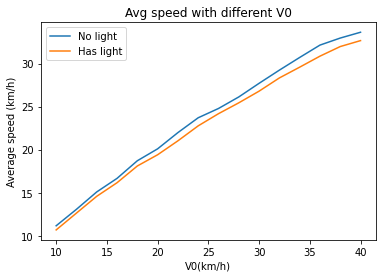

In [ ]:
plt.plot(v0s, performance_speed_1, label='No light')
plt.plot(v0s, performance_speed_1_light, label='Has light')

plt.title('Avg speed with different V0')
plt.xlabel('V0(km/h)')
plt.ylabel('Average speed (km/h)')
plt.legend()

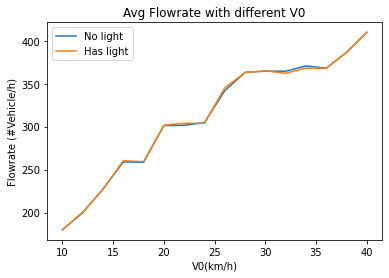

In [ ]:
plt.plot(v0s, performance_flow_1, label='No light')
plt.plot(v0s, performance_flow_1_light, label='Has light')

plt.title('Avg Flowrate with different V0')
plt.xlabel('V0(km/h)')
plt.ylabel('Flowrate (#Vehicle/h)')
plt.legend()

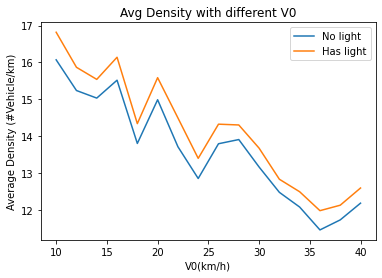

In [ ]:
plt.plot(v0s, performance_density_1, label='No light')
plt.plot(v0s, performance_density_1_light, label='Has light')

plt.title('Avg Density with different V0')
plt.xlabel('V0(km/h)')
plt.ylabel('Average Density (#Vehicle/km)')
plt.legend()

## experiment 5.2:  different light position

### one light, 60s per color, different pos, different v0, all polite car, human-truck: 0.8-0.2

In [ ]:
# HAS LIGHT: Compute the flowrate, density, and the average speed with different V0 
np.random.seed(2)
v0s = np.arange(10, 40.1, 2) #kmh

performance_density_2_lists = []
performance_flow_2_lists = []
performance_speed_2_lists = []

pos_lists = [0.25, 0.5, 0.75]

for pos in pos_lists:
  performance_density_2_light = []
  performance_flow_2_light = []
  performance_speed_2_light = []

  for v0 in v0s:
    print("############################################")
    print("light position = {:2.2f}".format(pos))
    print("initial speed = {:2.2f}".format(v0))
    print("############################################")
    speed2, density2, flow2 = calculation_v_d_f_light(2,v0,1,2400,7200,pos,60) #normal
    performance_density_2_light.append(density2)
    performance_flow_2_light.append(flow2)
    performance_speed_2_light.append(speed2)

  performance_density_2_lists.append(performance_density_2_light)
  performance_flow_2_lists.append(performance_flow_2_light)
  performance_speed_2_lists.append(performance_speed_2_light)
    

############################################
light position = 0.25
initial speed = 10.00
############################################


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars



############################################
light position = 0.25
initial speed = 12.00
############################################
############################################
light position = 0.25
initial speed = 14.00
############################################
############################################
light position = 0.25
initial speed = 16.00
############################################
############################################
light position = 0.25
initial speed = 18.00
############################################
############################################
light position = 0.25
initial speed = 20.00
############################################
############################################
light position = 0.25
initial speed = 22.00
############################################
############################################
light position = 0.25
initial speed = 24.00
############################################
############################################
light position = 

[10.679336451345739, 12.633910543434414, 14.58376561156487, 16.157861916428534, 18.101731532773936, 19.404936521825405, 21.023399037522402, 22.761726165425944, 24.174018085623757, 25.435006006807335, 26.78882053990267, 28.324378480859693, 29.573555518848337, 30.852077282449063, 31.968266847580473, 32.65763745791634]
[10.735558191427023, 12.744330356143369, 14.612037039167388, 16.264131700590436, 17.985257449470154, 19.39238932616477, 21.281554593478052, 22.97792621762011, 24.013785121931477, 25.228823519729815, 26.98235867129532, 28.40374378343047, 29.832263619867334, 31.213940380350465, 32.06415005848741, 32.72387953424765]
[10.888290756787715, 12.898232747086146, 14.457081314665478, 16.0168214298197, 18.122935557996485, 19.40427004802187, 21.378805596750954, 23.064642660538137, 24.228085073461855, 25.158872411560615, 26.836886482697114, 28.6086032975054, 29.831780061180496, 31.221535909441723, 31.97327920675663, 32.706917229117]


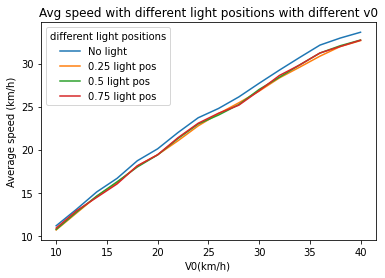

In [ ]:
plt.plot(v0s, performance_speed_1, label='No light')

for i in range(len(performance_speed_2_lists)):
  light_pos = pos_lists[i]
  light_speed = performance_speed_2_lists[i]
  print(light_speed)
  label_duration = str(light_pos) + " light pos"
  plt.plot(v0s, light_speed, label= label_duration)


plt.title('Avg speed with different light positions with different v0')
plt.xlabel('V0(km/h)')
plt.ylabel('Average speed (km/h)')
plt.legend(title = "different light positions")

[179.75027119859755, 200.50936711821058, 226.80573921776235, 260.41308781089805, 259.20953133889805, 301.6219064823708, 303.8299885645464, 304.0345270911359, 345.24848731779514, 362.97691490447215, 365.06484146807907, 362.10402182924327, 368.24229180881906, 367.88981895537137, 386.40856599352685, 409.92265689503415]
[178.69489080313517, 201.3497339598387, 226.48211713349608, 260.43174435775, 258.42350069087684, 302.59650372907043, 303.4376140924052, 304.0813791454266, 340.9857950627232, 366.3289616038633, 364.7621387301802, 365.17055906268934, 367.72238612713926, 370.0276865824599, 387.4739602229673, 408.3018807366076]
[182.41010284704123, 202.40069485072902, 225.1866480342126, 257.7115308266079, 261.28551523944395, 301.94686975080816, 304.04571319525803, 304.4848308512729, 344.03679493036253, 368.84061545657835, 366.650180044253, 364.3243811643078, 367.5014762776391, 364.6104120223519, 385.6426977447418, 409.19820231524767]


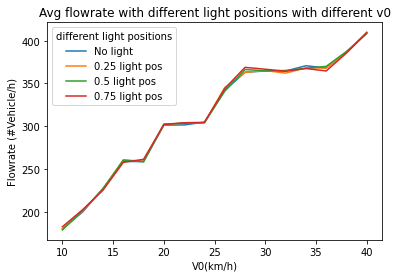

In [ ]:
plt.plot(v0s, performance_flow_1, label='No light')

for i in range(len(performance_flow_2_lists)):
  light_pos = pos_lists[i]
  light_flow = performance_flow_2_lists[i]
  print(light_flow)
  label_duration = str(light_pos) + " light pos"
  plt.plot(v0s, light_flow, label= label_duration)

plt.title('Avg flowrate with different light positions with different v0')
plt.xlabel('V0(km/h)')
plt.ylabel('Flowrate (#Vehicle/h)')
plt.legend(title = "different light positions")

[16.81981504824014, 15.870127410773994, 15.542304558895184, 16.1423473644966, 14.343205251872499, 15.58866085536244, 14.498424872224293, 13.402271064005225, 14.328657265215222, 14.307081861274346, 13.679299250606087, 12.836379040641651, 12.497213690691066, 11.984705381078347, 12.13277429612402, 12.598926309269485]
[16.643143311969986, 15.798373781667765, 15.50272910366649, 16.049141619472014, 14.400534182343973, 15.652030898937356, 14.3150955827381, 13.269119999684383, 14.252341979275778, 14.580411407199628, 13.566490710000927, 12.898639492013896, 12.385144878221025, 11.91406134417479, 12.130555111718676, 12.535556265694566]
[16.746212098796118, 15.699373499584768, 15.593222512195652, 16.149128205735163, 14.45736996072537, 15.614921204159048, 14.258752956446783, 13.251119948396566, 14.233355623807805, 14.737233771844174, 13.718504841767224, 12.782009022710643, 12.381322949522925, 11.734060831296617, 12.11933590166942, 12.570446776067527]


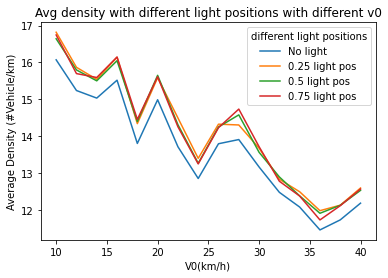

In [ ]:
plt.plot(v0s, performance_density_1, label='No light')

for i in range(len(performance_density_2_lists)):
  light_pos = pos_lists[i]
  light_density = performance_density_2_lists[i]
  print(light_density)
  label_duration = str(light_pos) + " light pos"
  plt.plot(v0s, light_density, label= label_duration)

plt.title('Avg density with different light positions with different v0')
plt.xlabel('V0(km/h)')
plt.ylabel('Average Density (#Vehicle/km)')
plt.legend(title = "different light positions")

## experiment 5.3:  different light duration

### one light, different color duration, pos: 1/4 road, different v0, all polite car, human-truck: 0.8-0.2

In [ ]:
# HAS LIGHT: Compute the flowrate, density, and the average speed with different V0 
np.random.seed(2)
v0s = np.arange(10, 40.1, 2) #kmh

performance_density_3_lists = []
performance_flow_3_lists = []
performance_speed_3_lists = []

duration_lists = [30, 45, 60, 75, 90]

for duration in duration_lists:
  performance_density_3_light = []
  performance_flow_3_light = []
  performance_speed_3_light = []

  for v0 in v0s:
    print("############################################")
    print("light duration = {:2.2f}".format(duration))
    print("initial speed = {:2.2f}".format(v0))
    print("############################################")
    speed3, density3, flow3 = calculation_v_d_f_light(2,v0,1,2400,7200,0.25,duration) #normal
    performance_density_3_light.append(density3)
    performance_flow_3_light.append(flow3)
    performance_speed_3_light.append(speed3)

  performance_density_3_lists.append(performance_density_3_light)
  performance_flow_3_lists.append(performance_flow_3_light)
  performance_speed_3_lists.append(performance_speed_3_light)

############################################
light duration = 30.00
initial speed = 10.00
############################################


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars



############################################
light duration = 30.00
initial speed = 12.00
############################################
############################################
light duration = 30.00
initial speed = 14.00
############################################
############################################
light duration = 30.00
initial speed = 16.00
############################################
############################################
light duration = 30.00
initial speed = 18.00
############################################
############################################
light duration = 30.00
initial speed = 20.00
############################################
############################################
light duration = 30.00
initial speed = 22.00
############################################
############################################
light duration = 30.00
initial speed = 24.00
############################################
############################################
light dura

[10.643109126929605, 12.857322083983114, 14.535040280608971, 16.29119324527331, 18.099360031285368, 19.46340445993028, 21.275013759157673, 23.03344511031807, 24.16114299688654, 25.20768271867687, 26.897063869754266, 28.188801283776403, 29.611484405122223, 31.121470083565015, 31.82031233256892, 32.684590315286954]
[10.707600771510945, 12.66481148543844, 14.585566317811406, 16.315045913426967, 17.90680393544135, 19.5135421771119, 21.29923315132323, 22.971389669938727, 24.037628061992727, 25.413994638100814, 26.765152173644605, 28.43180271895097, 29.747948942846563, 31.365469628926117, 31.74501875422659, 32.70065968138765]
[10.679336451345739, 12.633910543434414, 14.58376561156487, 16.157861916428534, 18.101731532773936, 19.404936521825405, 21.023399037522402, 22.761726165425944, 24.174018085623757, 25.435006006807335, 26.78882053990267, 28.324378480859693, 29.573555518848337, 30.852077282449063, 31.968266847580473, 32.65763745791634]
[10.781351941794608, 12.532439849348986, 14.6509092281

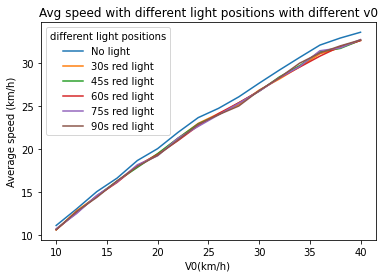

In [ ]:
plt.plot(v0s, performance_speed_1, label='No light')

for i in range(len(performance_speed_3_lists)):
  light_duration = duration_lists[i]
  light_speed = performance_speed_3_lists[i]
  print(light_speed)
  label_duration = str(light_duration) + "s red light"
  plt.plot(v0s, light_speed, label= label_duration)

plt.title('Avg speed with different light positions with different v0')
plt.xlabel('V0(km/h)')
plt.ylabel('Average speed (km/h)')
plt.legend(title = "different light positions")

[178.0029587838144, 200.3599692266434, 225.63879141580114, 258.29060494830924, 261.2895628272168, 303.4105325530132, 305.5978839407979, 305.39177089036326, 341.2294758994735, 363.3185952562589, 365.4278608039281, 363.297885929265, 367.3948360608492, 367.10735178720216, 384.9080885583822, 410.95191181510245]
[178.7670231476796, 197.72505569160307, 229.08888739411395, 258.8756473607732, 259.24310627376536, 303.03386105552005, 304.26020509214345, 305.6730749846573, 343.0959327118158, 361.55597218169146, 364.1332302785693, 368.4891863583967, 365.064786661692, 367.3767323998861, 385.9968127472813, 411.2435826687546]
[179.75027119859755, 200.50936711821058, 226.80573921776235, 260.41308781089805, 259.20953133889805, 301.6219064823708, 303.8299885645464, 304.0345270911359, 345.24848731779514, 362.97691490447215, 365.06484146807907, 362.10402182924327, 368.24229180881906, 367.88981895537137, 386.40856599352685, 409.92265689503415]
[179.7829129139054, 198.9988727237184, 225.60820375676008, 260.

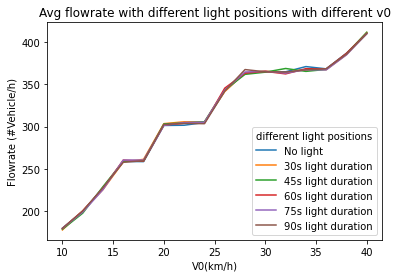

In [ ]:
plt.plot(v0s, performance_flow_1, label='No light')

for i in range(len(performance_flow_3_lists)):
  light_duration = duration_lists[i]
  light_flow = performance_flow_3_lists[i]
  print(light_flow)
  label_duration = str(light_duration) + "s light duration"
  plt.plot(v0s, light_flow, label= label_duration)

plt.title('Avg flowrate with different light positions with different v0')
plt.xlabel('V0(km/h)')
plt.ylabel('Flowrate (#Vehicle/h)')
plt.legend(title = "different light positions")

[16.743746338345733, 15.584962214686861, 15.515920922076054, 15.871976731111785, 14.455150776320023, 15.609249955123163, 14.389191684272197, 13.287489915039759, 14.151122512787435, 14.452931591914675, 13.624682656630037, 12.93303685029678, 12.457268371394813, 11.84588306772162, 12.14374693012824, 12.61199483965653]
[16.68296534324372, 15.586934823047171, 15.715770806579833, 15.876784963990037, 14.523082476728154, 15.563140234700944, 14.324218896404528, 13.344202405398637, 14.319164087481235, 14.267383118023133, 13.65427178203467, 13.001215126749953, 12.313021385047236, 11.753540338854664, 12.217473167594779, 12.616186632422188]
[16.81981504824014, 15.870127410773994, 15.542304558895184, 16.1423473644966, 14.343205251872499, 15.58866085536244, 14.498424872224293, 13.402271064005225, 14.328657265215222, 14.307081861274346, 13.679299250606087, 12.836379040641651, 12.497213690691066, 11.984705381078347, 12.13277429612402, 12.598926309269485]
[16.644129616150142, 15.896387759570604, 15.4033

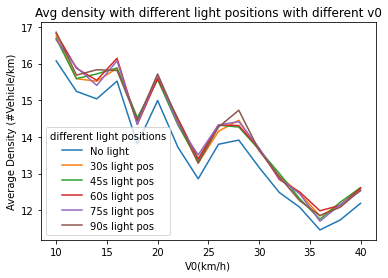

In [ ]:
plt.plot(v0s, performance_density_1, label='No light')

for i in range(len(performance_density_3_lists)):
  light_duration = duration_lists[i]
  light_density = performance_density_3_lists[i]
  print(light_density)
  label_duration = str(light_duration) + "s light pos"
  plt.plot(v0s, light_density, label= label_duration)

plt.title('Avg density with different light positions with different v0')
plt.xlabel('V0(km/h)')
plt.ylabel('Average Density (#Vehicle/km)')
plt.legend(title = "different light positions")

## experiment 5.4:  different duration vs different positions

### one light, xaxis: different positions [0, 1, :0.05], yaxis: different color duration [0, 150, :10], v0: 40, all polite car, human-truck: 0.8-0.2

### expected : 21 * 16 datapoint

In [ ]:
# HAS LIGHT: Compute the flowrate, density, and the average speed with different V0 
np.random.seed(2)

# v0s = np.arange(10, 40.1, 2) #kmh

performance_density_4_lists = []
performance_flow_4_lists = []
performance_speed_4_lists = []


duration_lists_4 = np.arange(0, 150.1, 10) #kmh
pos_lists_4 = np.arange(0,1.01, 0.05)

for pos in pos_lists_4:

  performance_density_4_light = []
  performance_flow_4_light = []
  performance_speed_4_light = []

  for duration in duration_lists_4:
    print("############################################")
    print("light pos = {:2.2f}".format(pos))
    print("initial duration = {:2.2f}".format(duration))
    print("############################################")
    speed4, density4, flow4 = calculation_v_d_f_light(2,40,1,2400,7200,pos,duration) #normal
    performance_density_4_light.append(density4)
    performance_flow_4_light.append(flow4)
    performance_speed_4_light.append(speed4)

  performance_density_4_lists.append(performance_density_4_light)
  performance_flow_4_lists.append(performance_flow_4_light)
  performance_speed_4_lists.append(performance_speed_4_light)


############################################
light pos = 0.00
initial duration = 0.00
############################################


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars



############################################
light pos = 0.00
initial duration = 10.00
############################################
############################################
light pos = 0.00
initial duration = 20.00
############################################
############################################
light pos = 0.00
initial duration = 30.00
############################################
############################################
light pos = 0.00
initial duration = 40.00
############################################
############################################
light pos = 0.00
initial duration = 50.00
############################################
############################################
light pos = 0.00
initial duration = 60.00
############################################
############################################
light pos = 0.00
initial duration = 70.00
############################################
############################################
light pos = 0.00
initial durati

In [ ]:
data = np.array(performance_flow_4_lists)

print(data.shape)

(21, 16)


In [ ]:
data

array([[409.71564458, 329.41650338, 333.9534664 , 337.10674549,
        334.26215798, 337.17489984, 333.10461599, 338.71769051,
        330.24590239, 333.55108204, 332.01656535, 323.74955551,
        330.8117113 , 319.27855051, 340.05074896, 338.27769331],
       [409.71564458, 386.20795878, 382.29905085, 387.05670077,
        393.4285921 , 381.73366269, 376.52675768, 385.09938543,
        387.54522067, 386.6383116 , 388.99717584, 393.1552082 ,
        378.36498197, 403.40427333, 378.52923879, 384.08530898],
       [409.71564458, 409.52362755, 407.60359941, 408.52396739,
        408.72612028, 405.27776428, 407.19141534, 408.35281715,
        406.81448443, 408.38935819, 407.10651952, 403.83641796,
        408.97575135, 409.06354055, 407.32100886, 406.32526447],
       [409.71564458, 408.54753626, 409.10374633, 408.37394335,
        410.15326697, 409.08175383, 408.93181964, 410.66964525,
        411.05139103, 411.42440298, 406.83668312, 408.17331952,
        408.55394644, 408.88836149, 4

Text(0, 0.5, 'position (percent of the road)')

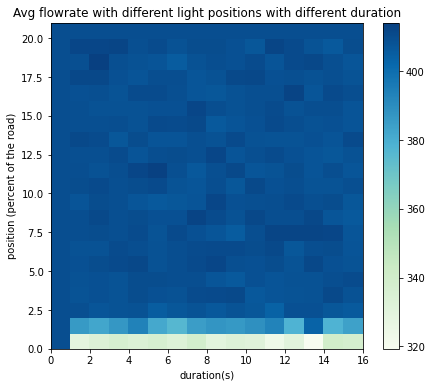

In [154]:
plt.figure(figsize=(7, 6)) 
map = plt.pcolormesh(data, cmap = 'GnBu')
plt.colorbar()


#TODO: change axises numbers
plt.title('Avg flowrate with different light positions with different duration')
plt.xlabel('duration(s)')
plt.ylabel('position (percent of the road)')



# different color map, change color map by replacing the cmap name with others
# https://matplotlib.org/3.5.0/tutorials/colors/colormaps.html

In [153]:
from google.colab import drive
import pandas as pd
drive.mount('drive')

df = pd.DataFrame(data)

df.to_csv('/content/drive/My Drive/color_map_data.csv', encoding='utf-8', index=False)


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
